In [116]:
import matplotlib.pyplot as pt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib as mpl

In [117]:
#locally weighted regression
def lwr(inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    for i in range(m):
        ypred[i] = inp[i] * beta(inp[i], inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def lwr1(x0, inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    ypred = x0 * beta(x0, inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def beta(point, inp, out, k):
    wt = kernal(point, inp, k)
    #print("The weight of betas is",wt)
    #print("Weight * inp" , (inp.T * (wt*inp)).I)
    out = out.reshape((inp.shape[0],1))
#     print(inp.shape)
#     print(wt.shape)
#     print(out.shape)
    beta_val = (inp.T * (wt*inp)).I * inp.T * wt * out
    #print("The weight is beta value is",beta_val)
    return beta_val

def kernal(point, inp, k):
    l,b = np.shape(inp)
    weights = np.mat(np.eye((l)))
    #print(weights)    
    for i in range(l):
        #print(point.shape,inp[i].shape)
        diff = point - inp[i]
        weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
    return weights

In [144]:
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = True

In [145]:
def sense_val_inflow(df):
    sense_vals = []
    for x in df['Inflow']:
        if(x <= 500):
            sense_vals.append(float(1))
        if((x > 500) and (x<=5000)):
            sense_vals.append(float(2))
        if((x > 5000) and (x <= 30000)):
            sense_vals.append(float(3))
        if((x > 30000) and (x <= 50000)):
            sense_vals.append(float(4))
        if(x > 50000):
            sense_vals.append(float(5))
    return sense_vals

In [146]:
#dataset preparation with lag
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [230]:
lag_val = 4

In [231]:
df = pd.read_csv('allYearLabeledHarangi.csv')
df
a = "RCDATE"
b = "Dates"
df['month'] = pd.DatetimeIndex(df[b]).month
df['year'] = pd.DatetimeIndex(df[b]).year
#df = df.sort_values(by = ['month','Dates'])
mask = (df['month'] <= 12)#&(df['month'] >=6))
mask1 = (df['year'] <= 2016)
df = df.loc[mask]
df = df.loc[mask1]
df.drop(['Label'],axis = 1,inplace = True)
#df['Avg'] = (df['MADIKERI']+df['SOMWARPET']+df['VIRAJPET'])/3
#df.to_csv(r"/home/ganesh/Downloads/avg_added_pred.csv")
df.set_index(b,inplace = True)
#df.to_csv(r"/home/ganesh/Downloads/avg_added_pred.csv")     
dataframe = pd.DataFrame(df, columns = ['MADIKERI', 'SOMWARPET', 'VIRAJPET'])
dataframe["minimum"] = dataframe.min(axis = 1)
df.drop(['month','year',"Present Storage(TMC)",'Reservoir Level(TMC)','Outflow'],axis = 1,inplace = True)
#df.drop(['Inflow'],axis = 1,inplace = True)
df['Label'] = sense_val_inflow(df)
#df.to_csv(r"/home/ganesh/Downloads/avg1_added_pred.csv") 
df.drop(['Inflow'],axis = 1,inplace = True)
# count = df['Label'].value_counts()
# count
df

,MADIKERI,SOMWARPET,VIRAJPET,Label
Dates,,,,
2011-01-01,0.000000,0.000000,0.000000,1.0
2011-01-02,0.000000,0.000000,0.000000,1.0
2011-01-03,0.000000,0.000000,0.000000,1.0
2011-01-04,0.000000,0.000000,0.000000,1.0
2011-01-05,0.000000,0.000000,0.000000,1.0
...,...,...,...,...
2016-12-27,1.065070,0.285446,0.029296,1.0
2016-12-28,1.083756,0.290454,0.029108,1.0
2016-12-29,1.102441,0.295462,0.028920,1.0


In [234]:
values = df.values
values = values.astype('float64')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# data=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# print(data.shape)
# idx = pd.date_range('2011-01-01', '2011-12-31') 
# data.set_index(idx)
# frame as supervised learning
reframed = series_to_supervised(values, lag_val,2)#lag of 4 days
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-2,-3,-4,-5]], axis=1, inplace=True)
reframed


,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t+1)
4,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0
5,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0
6,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0
7,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0
8,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,0.971643,0.260407,0.030235,1.0,0.990329,0.265415,0.030047,1.0,1.009014,0.270423,0.029859,1.0,1.027700,0.275430,0.029671,1.0,1.046385,0.280438,0.029484,1.0
2187,0.990329,0.265415,0.030047,1.0,1.009014,0.270423,0.029859,1.0,1.027700,0.275430,0.029671,1.0,1.046385,0.280438,0.029484,1.0,1.065070,0.285446,0.029296,1.0
2188,1.009014,0.270423,0.029859,1.0,1.027700,0.275430,0.029671,1.0,1.046385,0.280438,0.029484,1.0,1.065070,0.285446,0.029296,1.0,1.083756,0.290454,0.029108,1.0
2189,1.027700,0.275430,0.029671,1.0,1.046385,0.280438,0.029484,1.0,1.065070,0.285446,0.029296,1.0,1.083756,0.290454,0.029108,1.0,1.102441,0.295462,0.028920,1.0


In [235]:
# colA = np.array(data.loc[:,['MADIKERI','SOMWARPET','VIRAJPET']])
# colB = np.array(data['Inflow'])

# l,b = np.shape(colA)
# l,b
# print(np.shape(colA))
# print(np.shape(colB))
# colA
# colB = colB.T
# t_vals = []
# for i in range(l):
#     a = colA[i]
#     b = colB[i]
#     t_vals.append((a,b))
# #t_vals = np.array(t_vals)
# print(t_vals)
# np.shape(t_vals)


In [236]:
values = reframed.values
train_x = values[:,:-1]
#print(train_x)
train_y = values[:,-1]
train_y = train_y.reshape((train_x.shape[0],1))
print(train_x.shape)
print(train_y.shape)
train_x.shape
inp = values
train_x
train_y

(2187, 19)
(2187, 1)


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [237]:
df1 = pd.read_csv('allYearLabeledHarangi.csv')
df1
a = "RCDATE"
b = "Dates"
df1['month'] = pd.DatetimeIndex(df1[b]).month
df1['year'] = pd.DatetimeIndex(df1[b]).year
mask = (df1['month'] <= 12)#&(df1['month'] >=1))
mask1 = (df1['year'] == 2018)
#df1 = df1.loc[mask]
df1 = df1.loc[mask1]
df1.drop(['Label'],axis = 1,inplace = True)
#df['Avg'] = (df['MADIKERI']+df['SOMWARPET']+df['VIRAJPET'])/3
#df.to_csv(r"/home/ganesh/Downloads/avg_added_pred.csv")
df1.set_index(b,inplace = True)
#df.to_csv(r"/home/ganesh/Downloads/avg_added_pred.csv")     
dataframe = pd.DataFrame(df1, columns = ['MADIKERI', 'SOMWARPET', 'VIRAJPET'])
dataframe["minimum"] = dataframe.min(axis = 1)
df1.drop(['month','year',"Present Storage(TMC)",'Reservoir Level(TMC)','Outflow'],axis = 1,inplace = True)
#df.drop(['Inflow'],axis = 1,inplace = True)
df1['Label'] = sense_val_inflow(df1)
#df.to_csv(r"/home/ganesh/Downloads/avg1_added_pred.csv") 
df1.drop(['Inflow'],axis = 1,inplace = True)
df1
# count = df1['Label'].value_counts()
# count

,MADIKERI,SOMWARPET,VIRAJPET,Label
Dates,,,,
2018-01-01,0.040023,0.922238,0.0,1.0
2018-01-02,0.040669,0.937113,0.0,1.0
2018-01-03,0.041315,0.951987,0.0,1.0
2018-01-04,0.041960,0.966862,0.0,1.0
2018-01-05,0.042606,0.981737,0.0,1.0
...,...,...,...,...
2018-12-27,0.000000,0.000000,0.0,1.0
2018-12-28,0.000000,0.000000,0.0,1.0
2018-12-29,0.000000,0.000000,0.0,1.0


In [238]:
values1 = df1.values
values1 = values1.astype('float64')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values1)
# data1=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# print(data1.shape)
# idx = pd.date_range('2012-01-01', '2018-12-31') 
# data1.set_index(idx)
# frame as supervised learning
reframed1 = series_to_supervised(values1, lag_val, 2)#lag of 4 days
# drop columns we don't want to predict1
reframed1.head()
reframed1.drop(reframed1.columns[[-2,-3,-4,-5]], axis=1, inplace=True)
reframed1

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t+1)
4,0.040023,0.922238,0.0,1.0,0.040669,0.937113,0.0,1.0,0.041315,0.951987,0.0,1.0,0.041960,0.966862,0.0,1.0,0.042606,0.981737,0.0,1.0
5,0.040669,0.937113,0.0,1.0,0.041315,0.951987,0.0,1.0,0.041960,0.966862,0.0,1.0,0.042606,0.981737,0.0,1.0,0.043251,0.996612,0.0,1.0
6,0.041315,0.951987,0.0,1.0,0.041960,0.966862,0.0,1.0,0.042606,0.981737,0.0,1.0,0.043251,0.996612,0.0,1.0,0.043897,1.011487,0.0,1.0
7,0.041960,0.966862,0.0,1.0,0.042606,0.981737,0.0,1.0,0.043251,0.996612,0.0,1.0,0.043897,1.011487,0.0,1.0,0.044542,1.026362,0.0,1.0
8,0.042606,0.981737,0.0,1.0,0.043251,0.996612,0.0,1.0,0.043897,1.011487,0.0,1.0,0.044542,1.026362,0.0,1.0,0.045188,1.041236,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0
360,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0
361,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0
362,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0


In [239]:
values1 = reframed1.values
test_y = values1[:,-1]
test_x = values1[:,:-1]
test_y = test_y.reshape(test_x.shape[0],1) 
print(train_x.shape,train_y.shape)
print(test_x.shape)
print(test_y.shape)
#print(list(Actuall_inflow))
Q_point = values1
Q_point
values

(2187, 19) (2187, 1)
(360, 19)
(360, 1)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [1.00901408, 0.27042254, 0.02985915, ..., 0.29045383, 0.02910798,
        1.        ],
       [1.02769953, 0.27543036, 0.02967136, ..., 0.29546166, 0.02892019,
        1.        ],
       [1.04638498, 0.28043818, 0.02948357, ..., 0.30046948, 0.02873239,
        1.        ]])

In [240]:
# def create_qry_point(start,end):
#     query_data = np.array(Rain_data.iloc[start:end,:],dtype = float)
#     return query_data
        #40
# q_point = create_qry_point(1000,2000)
# q_point = np.mat([[137.695,57.25,80.2333333333333,36179],[123.0475,76.86,78.515,33901]])
# print(q_point)
# print(len(q_point))
# q_point.shape

In [241]:
print(Q_point.shape)
print(inp.shape)
inp

(360, 20)
(2187, 20)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [1.00901408, 0.27042254, 0.02985915, ..., 0.29045383, 0.02910798,
        1.        ],
       [1.02769953, 0.27543036, 0.02967136, ..., 0.29546166, 0.02892019,
        1.        ],
       [1.04638498, 0.28043818, 0.02948357, ..., 0.30046948, 0.02873239,
        1.        ]])

In [242]:
def euclid_dist(points, q_point):
    mini = 100000000
    store_point = 0
    for point in points:
        val = np.linalg.norm(point - q_point)
        if(mini > val):
            mini = val
            store_point = point
    return list(store_point)
    

In [243]:
distance = list()
points = inp 
for single_point in Q_point:
    distance.append(euclid_dist(points,single_point))

In [244]:
distance = np.array(distance)
distance
train_knn_y = distance[:,-1]
train_knn_x = distance[:,:-1]
print(train_knn_y.shape)
print(train_knn_x.shape)

(360,)
(360, 19)


In [245]:
ypred = []
for i in test_x:
    ypred.append(lwr1(i, train_knn_x, train_knn_y, 100))
ypred = np.array(ypred).reshape(test_y.shape[0],1)
Actuall_inflow=test_y.reshape(test_y.shape[0],1)

In [246]:
ypred = np.round(ypred)
df3 = pd.DataFrame()
df3['predicted'] = list(ypred)
df3['Actuall'] = Actuall_inflow
df3.to_csv(r"/home/ganesh/Downloads/choice_added_pred.csv") 
#print((ypred,Actuall_inflow))

In [250]:
print("MSE = ",metrics.mean_squared_error(Actuall_inflow,ypred))
print("RMSE = ",sqrt(metrics.mean_squared_error(Actuall_inflow,train_knn_y)))
print("RMSE = ",sqrt(metrics.mean_squared_error(Actuall_inflow,ypred)))
print("Scuurace = " ,metrics.accuracy_score(Actuall_inflow[0:-2],ypred[2:]))
print("Scuurace1 = " ,metrics.accuracy_score(Actuall_inflow,train_knn_y))

MSE =  0.1361111111111111
RMSE =  0.6390096504226938
RMSE =  0.3689323936863109
Scuurace =  0.9078212290502793
Scuurace1 =  0.6555555555555556


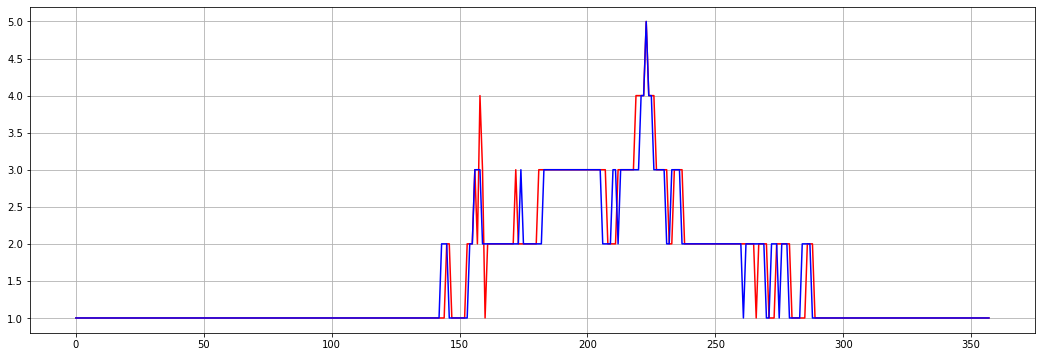

In [251]:
#pt.plot(train_knn_y,c='red')
pt.plot(ypred[2:],c='red')
pt.plot(Actuall_inflow[0:-2],c='blue')

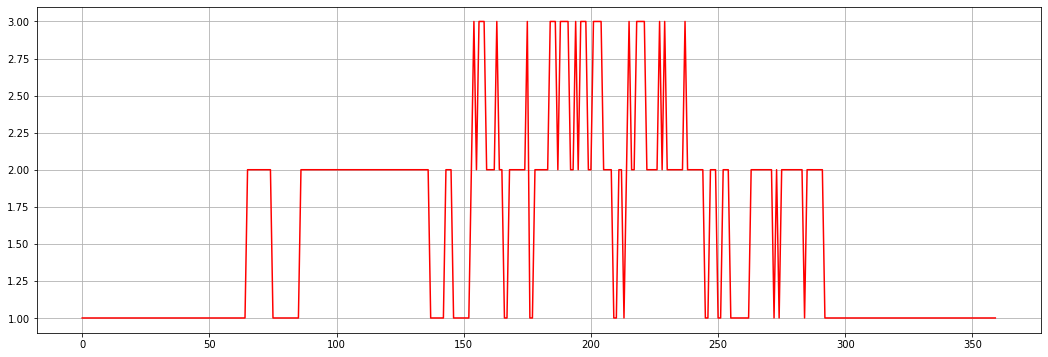

In [210]:
pt.plot(train_knn_y,c='red')

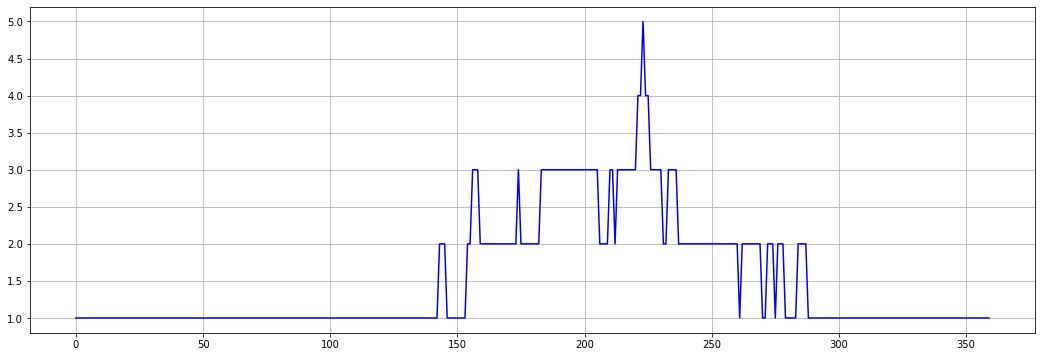

In [211]:
pt.plot(Actuall_inflow,c='blue')

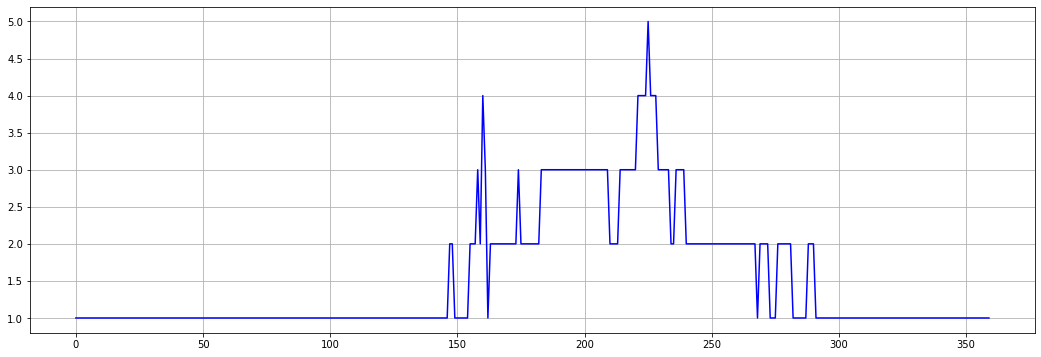

In [212]:
pt.plot(ypred,c='blue')

In [155]:
# distance = []
# for single_point in Q_point:
#         #print(single_point)
#         points = inp 
#         #print(points)
#         distance.append(euclid_dist(single_point,points))
# distance
# min_val = np.amin(distance,axis = 0) 
# min_val.shape

In [156]:
# def cal_eucledian_distance(q_point,inp1):
#     #print(q_point,inp1)
#     q_point = list(q_point)
#     #print(q_point.shape)
#     print(inp1.shape)
#     a = np.linalg.norm(q_point - inp1)
#     print(a)

In [157]:
# #for q_point in Q_point:
# abc = cal_eucledian_distance(Q_point[0],inp)

In [158]:
# def knn(inp1,k,q_point):
#     tup_val = []
#     distance_list = [cal_eucledian_distance(Q_point,inp1[i]) for i in range(len(inp1))]
#     #print(distance_list)
#     for i in range(len(inp1)):
#         tup_val.append((distance_list[i],inp1[i]))
#     #print("---------------------------")
#     #print(tup_val)
#     index=0
#     sorted_values = sort(tup_val)
#     neighbours = sorted_values[:k]
#     return neighbours

In [159]:
# def last(n):
#     m =0
#     return n[m]

In [160]:
# def sort(tuples):
#     return sorted(tuples,key=last)

In [19]:
inp1 = t_vals
vals = knn(inp1,10,q_point)
print(vals)
len(vals)

[(20731.981515523323, array([[   42.9525,    31.8   ,    25.085 , 20425.    ]])), (23297.686961347703, array([[2.67125000e+01, 1.83850000e+01, 1.48183333e+01, 1.86060000e+04]])), (24399.328760307188, array([[   47.7375    ,    33.08      ,    35.29666667, 17825.        ]])), (25855.892008067804, array([[   35.975     ,    32.77833333,    24.51333333, 16793.        ]])), (28072.26480699056, array([[   34.2625    ,    21.96833333,    17.76666667, 15223.        ]])), (28472.884040877885, array([[   70.74      ,    52.415     ,    45.90666667, 14939.        ]])), (29992.39079578066, array([[   56.78      ,    41.05      ,    25.89166667, 13863.        ]])), (30037.87962054293, array([[2.85500000e+01, 1.20950000e+01, 1.18066667e+01, 1.38310000e+04]])), (30369.803755501955, array([[2.19325000e+01, 1.40566667e+01, 6.47166667e+00, 1.35960000e+04]])), (30756.227591805935, array([[   77.865     ,    60.06333333,    48.285     , 13322.        ]]))]


10

In [20]:
print(vals[0])

(20731.981515523323, array([[   42.9525,    31.8   ,    25.085 , 20425.    ]]))


In [21]:
near_vals = []
for i in range(len(vals)):
    near_vals.append(vals[i][1])

In [22]:
near_vals = np.array(near_vals)
near_vals.shape

(10, 1, 4)

In [23]:
np.shape(near_vals)

(10, 1, 4)

In [24]:
len(near_vals) 

10

In [25]:
def normalize(mcolB, max_val, min_val):
    #print(mcolB)
    n_val = []
    for i in range(len(mcolB)):
        n_val.append(float(((mcolB[i] - min_val) / (max_val - min_val))))
    return n_val
    #return ( (point - m) / () )

In [26]:
near_vals = np.append(near_vals,[[[123.0475,76.86,78.515,33901]]],axis = 0)
near_vals[:,0:3]


array([[[4.29525000e+01, 3.18000000e+01, 2.50850000e+01, 2.04250000e+04]],

       [[2.67125000e+01, 1.83850000e+01, 1.48183333e+01, 1.86060000e+04]],

       [[4.77375000e+01, 3.30800000e+01, 3.52966667e+01, 1.78250000e+04]],

       [[3.59750000e+01, 3.27783333e+01, 2.45133333e+01, 1.67930000e+04]],

       [[3.42625000e+01, 2.19683333e+01, 1.77666667e+01, 1.52230000e+04]],

       [[7.07400000e+01, 5.24150000e+01, 4.59066667e+01, 1.49390000e+04]],

       [[5.67800000e+01, 4.10500000e+01, 2.58916667e+01, 1.38630000e+04]],

       [[2.85500000e+01, 1.20950000e+01, 1.18066667e+01, 1.38310000e+04]],

       [[2.19325000e+01, 1.40566667e+01, 6.47166667e+00, 1.35960000e+04]],

       [[7.78650000e+01, 6.00633333e+01, 4.82850000e+01, 1.33220000e+04]],

       [[1.23047500e+02, 7.68600000e+01, 7.85150000e+01, 3.39010000e+04]]])

In [27]:
near_len = len(near_vals)
near_len

11

In [28]:
x = near_vals.reshape(near_len,4)

In [29]:
print(len(Dam_data))

2918


In [30]:
mcolA = x[:,0:3]
mcolB = x[:,-1]

In [31]:
mcolA 

array([[ 42.9525    ,  31.8       ,  25.085     ],
       [ 26.7125    ,  18.385     ,  14.81833333],
       [ 47.7375    ,  33.08      ,  35.29666667],
       [ 35.975     ,  32.77833333,  24.51333333],
       [ 34.2625    ,  21.96833333,  17.76666667],
       [ 70.74      ,  52.415     ,  45.90666667],
       [ 56.78      ,  41.05      ,  25.89166667],
       [ 28.55      ,  12.095     ,  11.80666667],
       [ 21.9325    ,  14.05666667,   6.47166667],
       [ 77.865     ,  60.06333333,  48.285     ],
       [123.0475    ,  76.86      ,  78.515     ]])

In [32]:
mcolB

array([20425., 18606., 17825., 16793., 15223., 14939., 13863., 13831.,
       13596., 13322., 33901.])

In [33]:
# a = list(mcolA)
# b = list(mcolB)
# b
# a
inp_matrix = mcolA

In [34]:
# reg_val = []
# mcolB = []
# mcolA = []
# for i in range(len(t_vals)):
#     if t_vals[i][0] in near_vals:
#         reg_val.append((t_vals[i][0],t_vals[i][1]))
#         mcolA.append(t_vals[i][0])
#         mcolB.append(t_vals[i][1])
#         #print("True")
# #print(q_point)
# #print(reg_val)
# print(reg_val)
# size_b = len(mcolB)
# mcolB = np.array(mcolB)
# mcolA = np.array(mcolA)
# mcolB = mcolB.reshape((size_b,1))
# max_val = np.max(mcolB)
# min_val = np.min(mcolB)
# print(np.shape(mcolB))
# print(np.shape(mcolA))
# #print(mcolA1[0])
# print(mcolB)



In [35]:
size_b = len(mcolB)
#print(size_b)
max_val = np.max(mcolB)
min_val = np.min(mcolB)
mcolB = mcolB.reshape(size_b,1)
mcolB.shape

(11, 1)

In [36]:
mcolA.shape

(11, 3)

In [37]:
normalized_tar_val = normalize(mcolB,max_val,min_val)
print(normalized_tar_val)
print(np.max(normalized_tar_val))
normalized_tar_val = np.array(normalized_tar_val)
normalized_tar_val = normalized_tar_val.reshape(size_b,1)
print(np.shape(normalized_tar_val))

[0.3451576850187084, 0.25676660673502116, 0.21881529714757764, 0.16866708780795958, 0.0923757228242383, 0.07857524661062248, 0.026288935322416055, 0.024733952087079063, 0.013314543952573012, 0.0, 1.0]
1.0
(11, 1)


In [38]:
q_point = q_point[:,0:3]
q_point.shape
print(q_point)
q_point[0].shape

[[137.695       57.25        80.23333333]
 [123.0475      76.86        78.515     ]]


(1, 3)

In [39]:
q_point[:,0:4]

matrix([[137.695     ,  57.25      ,  80.23333333],
        [123.0475    ,  76.86      ,  78.515     ]])

In [40]:
def lwr(inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)
    
    for i in range(m):
        ypred[i] = inp[i] * beta(inp[i], inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred
    

In [41]:
def lwr1(x0, inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)
    
    ypred = x0 * beta(x0, inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred


In [42]:
def beta(point, inp, out, k):
    wt = kernal(point, inp, k)
    #print("The weight of betas is",wt)
    beta_val = (inp.T * (wt*inp)).I * (inp.T * wt * out)
    #print("The weight is beta value is",beta_val)
    
    return beta_val

In [43]:
def kernal(point, inp, k):
    l,b = np.shape(inp)
    weights = np.mat(np.eye((l)))
    #print(weights)
    
    for i in range(l):
        diff = point - inp[i]
        #diff = np.array(diff)
        #print("Hi",len(diff))
        #print(diff.shape)
        #diff = diff.reshape(len(diff),1)
        #print(np.shape(diff))
        #diff1 = diff.T
        #print(np.shape(diff.T))
        #a = np.dot(diff,diff.T)
        #print(a)
        
        #print(a)
        #print(np.shape(a))
        weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
        #print(weights[i,i])
    #print("The weights of",i,'is',weights[i,i])
    
    return weights

In [44]:
#mcolB = normalized_tar_val
print(inp_matrix.shape)
print(mcolB.shape)
print(q_point)
print("----------------------")
print(inp_matrix)
print("-----------------------------------------------")
#ypred = lwr(inp_matrix, mcolB, 6)
for i in range(len(q_point)):
    
    ypred1 = lwr1(q_point[i], inp_matrix, mcolB, 1.5)
ypred = np.array(ypred)
print(mcolB)
#print(normalized_tar_val)
#print(ypred)
print("=======================================================")
print(ypred1)
print(np.shape(mcolB))

xsort = inp_matrix.copy()
xsort.sort(axis = 0)
print(np.shape(mcolA))

f, (ax1, ax2) = pt.subplots(1, 2, sharey=True)
pt.plot(xsort[:,1],ypred[mcolA[:,1].argsort(0)],color = 'yellow',linewidth = 5)#ypred[X[:, 1].argsort(0)]
ax1.set_title('Sharing Y axis')
ax2.scatter(mcolA, mcolB)

pt.scatter(mcolA,mcolB,color = 'blue')
pt.plot(xsort[:,1],ypred[mcolA[:,1].argsort(0)],color = 'yellow',linewidth = 5)#ypred[X[:, 1].argsort(0)]
#pt.plot(xsort[:, 1], ypred[X[:, 1].argsort(0)], color='yellow', linewidth=5)
pt.xlabel('MADIKERI')
pt.ylabel('Inflow')

(11, 3)
(11, 1)
[[137.695       57.25        80.23333333]
 [123.0475      76.86        78.515     ]]
----------------------
[[ 42.9525      31.8         25.085     ]
 [ 26.7125      18.385       14.81833333]
 [ 47.7375      33.08        35.29666667]
 [ 35.975       32.77833333  24.51333333]
 [ 34.2625      21.96833333  17.76666667]
 [ 70.74        52.415       45.90666667]
 [ 56.78        41.05        25.89166667]
 [ 28.55        12.095       11.80666667]
 [ 21.9325      14.05666667   6.47166667]
 [ 77.865       60.06333333  48.285     ]
 [123.0475      76.86        78.515     ]]
-----------------------------------------------


LinAlgError: Singular matrix

In [578]:
from sklearn import metrics

In [324]:
metrics.accuracy_score(mcolB, ypred)

ValueError: continuous is not supported

In [974]:
import math
math.sqrt(metrics.mean_squared_error(mcolB,ypred))

ValueError: Found input variables with inconsistent numbers of samples: [12, 25]